<a href="https://colab.research.google.com/github/ykitaguchi77/ImageProcessing/blob/master/Eye_crop1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・検出された目周囲の画像を縦横とも1.1倍の幅で切り抜く
・切り取った画像を250px*250pxにresizeする<br>
・対応表をCSV形式で出力（連番、左右、元フォルダ、元画像名）

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import csv
from random import randint
from time import sleep

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [3]:
'''
変換前
--in-----1-----abc.jpg
      |    |--def.jpg
      |
      |-2-----ghi.jpg     
           |--jkl.jpg

変換後
--out-------1.jpg
        |--2,jpg        
        |--3.jpg
        |--4.jpg
'''

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#元画像フォルダ
in_path = '/content/drive/My Drive/Deep_learning/eyelid_images/in'

#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/eyelid_images/out'

#CSVファイルのフォルダ
csv_path = '/content/drive/My Drive/Deep_learning/eyelid_images/eyelid_images.csv'


#Haarcascadeを指定

In [0]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#画像を切り抜いて連番で出力、対応表出力
12時間で60000枚を処理するのは不可能（1秒間に3枚として12000枚 =フォルダ1600個ぐらいが限界）<br>
→1回のセッションでフォルダ1000個ずつを処理することとする

In [8]:
処理するDirectoryの設定
directory = os.listdir(in_path)
print(len(directory))

#ここにフォルダ番号を記載する (ex. [0:999])
processing_directory = directory[1000:1999]
print(processing_directory)

8196
['6214', '6213', '6209', '6208', '6211', '6212', '6210', '6215', '6218', '6226', '6228', '6220', '6225', '6221', '6223', '6224', '6219', '6217', '6216', '6222', '6227', '6230', '6229', '6233', '6234', '6231', '6235', '6232', '6236', '6241', '6240', '6239', '6237', '6238', '6247', '6245', '6243', '6244', '6246', '6242', '6248', '6249', '6254', '6255', '6252', '6250', '6253', '6251', '6256', '6257', '6260', '6259', '6258', '6261', '6262', '6263', '6264', '6265', '6267', '6266', '6268', '6269', '6271', '6270', '6272', '6274', '6276', '6277', '6275', '6273', '6278', '6282', '6283', '6281', '6280', '6279', '6284', '6287', '6290', '6286', '6288', '6289', '6285', '6296', '6293', '6294', '6295', '6291', '6292', '6300', '6302', '6301', '6298', '6297', '6299', '6307', '6304', '6305', '6303', '6306', '6310', '6308', '6318', '6312', '6309', '6316', '6313', '6311', '6315', '6317', '6314', '6319', '6320', '6326', '6321', '6327', '6322', '6324', '6325', '6323', '6329', '6331', '6328', '6330', '6

In [6]:
#処理時間の計測
start = time.time()

with open(csv_path, 'a', newline='') as f:  #a:追記モード
        writer = csv.writer(f)
        fieldnames = ['Number', 'Folder', 'FileName']       
        writer.writerow(['Folder', 'Image_num', 'side (R:0, L:1)', 'ImageName', 'Number'])  #header
        
        k=0
        for i in processing_directory:  #フォルダ数の分だけ
              file = os.listdir(in_path + '/' + i)

              l=0
              for j in file:
                    l+=1
                    print(str(l))
                    print('')
                    img = cv2.imread(in_path + '/' + i + '/' + j) 
                    img2 = img.copy()

                    # 画像グレースケール化
                    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                    #300pix以上のもので目に見えるものを抽出
                    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
                    print('image path = '+ in_path + '/' + i + '/' + j )
                    
                    # 眼検出判定
                    if len(eye_list) >= 1:
                        '''
                        print('目が' + str(len(eye_list)) +'個検出されました')
                        '''
                        pass
                    else:
                        '''
                        print("eye detection error")
                        '''
                        break

                    #画像の切り抜きと保存（連番にする）
                    
                    m=0
                    for (ex, ey, ew, eh) in eye_list:
                        m+=1
                        #print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                        try:
                          cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                          img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)]
                          img_resized = cv2.resize(img_cropped,(250,250)) #1辺250pixにresize 
                          #x, y = random.randint(0,27), random.randint(0,27) #ランダムな位置で224pixに切り取る
                          #img_randcrop = img_resized[y: y+223, x: x+223]
                        except:
                            pass

                        if ex <= 600:
                            side = 0 #600ピクセル目より左にあるのは右眼
                        else:
                            side = 1 #600ピクセル目より右にあるのは左眼
                        
                        '''
                        print('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+str(i)+'-' + str(l) + '-' + str(side)+ '.jpg')
                        '''

                        #保存する際のよくわからないエラーをskipする
                        try:
                            cv2.imwrite('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+str(i)+'-' + str(l) + '-' + str(side)+ '.jpg', img_resized)
                            #対応表の作成
                            writer.writerow([str(i), str(l),side, str(j), str(k+1)])
                            k+=1
                        except:
                            pass

print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


8196
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7205/20161026100647_眼位_O_0_5822da434f9adf128e50d316ab8501dedfb4024cc8554166e5f2c4a11871fce1.jpg
目が2個検出されました
/content/drive/My Drive/Deep_learning/eyelid_images/out/7205-1-1.jpg
/content/drive/My Drive/Deep_learning/eyelid_images/out/7205-1-0.jpg
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7211/20171225104232_眼位_O_0_d888889cbd4e71e48c50f76f3984f5d065ddd2fe83fc2ec64611813563408bda.jpg
目が2個検出されました
/content/drive/My Drive/Deep_learning/eyelid_images/out/7211-1-1.jpg
/content/drive/My Drive/Deep_learning/eyelid_images/out/7211-1-0.jpg
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/7213/20091216105257_眼位_O_0_881f815eed7ee3d4b69af2d4cb7851bb7c4275328941e3ee843eac239163bd5d.jpg
目が2個検出されました
/content/drive/My Drive/Deep_learning/eyelid_images/out/7213-1-0.jpg
/content/drive/My Drive/Deep_learning/eyelid_images/out/7213-1-1.jpg
2

image path = /content/drive/My Drive/Deep

#切り取られた図を表示してみる

['.ipynb_checkpoints', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg']


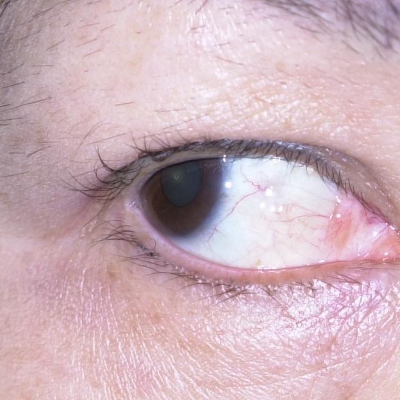

In [0]:
img_list = os.listdir('/content/drive/My Drive/Deep_learning/eyelid_images/out')
print(img_list)
img = cv2.imread('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+img_list[12])


#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)
dst = scale_to_width(img, 400)

#図を表示する
cv2_imshow(dst)